# Symbolic calculation

In [4]:
import sympy
from sympy import cos, sin
sympy.init_printing()

In [5]:
x0, y0, alpha0 = sympy.symbols("x_0, y_0, alpha_0")
x, y = sympy.symbols("x, y")
l, l1, l2, l3 = sympy.symbols("l, l_1, l_2, l_3")
r1, r2, r3, r4 = sympy.symbols("r_1, r_2, r_3, r_4")
r01, r02, r03, r04 = sympy.symbols("r0_1, r0_2, r0_3, r0_4")
# l_1 - distance between center and 1, 2 sensors
# l_2 - distance along y axes from center to 3, 4 sensors
# l - side of cubes
L_x = sympy.Equality(sin(alpha0) * (x - x0) + cos(alpha0) * (y - y0), 0)
L_y = sympy.Equality(cos(alpha0) * (x - x0) + sin(alpha0) * (y - y0), 0)

In [6]:
x1, y1 = x0 + cos(alpha0) * 3 * l / 2, y0 + sin(alpha0) * 3 * l / 2
x2, y2 = x0 - cos(alpha0) * 3 * l / 2, y0 - sin(alpha0) * 3 * l / 2
x3, y3 = x0 - sin(alpha0) * l / 2, y0 + cos(alpha0) * l / 2
L1 = sympy.Equality(cos(alpha0) * (x - x1) + sin(alpha0) * (y - y1), 0)
L2 = sympy.Equality(cos(alpha0) * (x - x2) + sin(alpha0) * (y - y2), 0)
L3 = sympy.Equality(sin(alpha0) * (x - x3) + cos(alpha0) * (y - y3), 0)

In [7]:
r_c = [None, None, None, None]

In [8]:
r_c[0] = r01 + 3 * l / 2 - sympy.solve(L1.subs(y, 0), x)[0]
r_c[3] = r04 + 3 * l / 2 + sympy.solve(L2.subs(y, 0), x)[0]

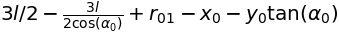

In [9]:
r_c[0]

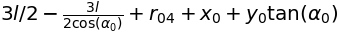

In [10]:
r_c[3]

In [11]:
r_c[1] = r02 + l / 2 - sympy.solve(L3.subs(x, l2), y)[0]
r_c[2] = r03 + l / 2 - sympy.solve(L3.subs(x, -l2), y)[0]

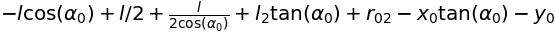

In [12]:
r_c[1]

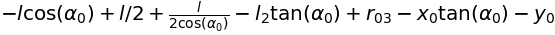

In [13]:
r_c[2]

In [14]:
r0s = [r01, r02, r03, r04]

In [15]:
r_f = [sympy.lambdify((x0, y0, alpha0, l, l2, y_), x_) for x_, y_ in zip(r_c, r0s)]

In [16]:
print(r_c)

[3*l/2 - 3*l/(2*cos(alpha_0)) + r0_1 - x_0 - y_0*tan(alpha_0), -l*cos(alpha_0) + l/2 + l/(2*cos(alpha_0)) + l_2*tan(alpha_0) + r0_2 - x_0*tan(alpha_0) - y_0, -l*cos(alpha_0) + l/2 + l/(2*cos(alpha_0)) - l_2*tan(alpha_0) + r0_3 - x_0*tan(alpha_0) - y_0, 3*l/2 - 3*l/(2*cos(alpha_0)) + r0_4 + x_0 + y_0*tan(alpha_0)]


# Numeric 

In [17]:
import scipy.optimize
import numpy as np

In [18]:
l = 58
l2 = 125 / 2
r0s = np.array([35, 85, 85, 35])
rs = np.array([33, 95, 75, 33])

In [19]:
def fun(X, l, l2, r0s, rs):
    return np.array([f_(X[0], X[1], X[2], l, l2, r0_) - r_ for f_, r0_, r_
                     in zip(r_f, r0s, rs)])

In [20]:
fun([0, 0, 0], l, l2, r0s, rs)

array([  2., -10.,  10.,   2.])

In [21]:
x, y, a = scipy.optimize.least_squares(fun, np.array([0, 0, 0]), 
                             bounds=[(-30, -30, -np.pi / 6), (30, 30, np.pi / 6)], 
                             args=[l, l2, r0s, rs]).x

# Movement

In [22]:
def get_movement(point):
    x, y, a = point
    R = np.sqrt(x ** 2 + y ** 2) / 2 / np.sin(a / 2)
    S = R * a
    angle = np.arctan2(y, x) + np.pi - a / 2
    return np.array([S * np.cos(angle), S * np.sin(angle), a])

In [20]:
X, Y, A

NameError: name 'X' is not defined

In [138]:
sensors

array(<map object at 0x7f3f67c5b438>, dtype=object)

# Test movements on robot

In [1]:
import sys
sys.path.insert(0, r"/home/mikhail/catkin_ws/src/ros-eurobot-2018/eurobot/scripts/stm_node")
import STMprotocol
import serial
import time

In [ ]:
protocol = STMprotocol.STMprotocol("/dev/USB0")

In [ ]:
protocol.pure_send_command(0x01, [ord(c) for c in 'ECHO'])

In [29]:
ser = serial.Serial("/dev/ttyACM0", timeout=0.02)

In [52]:
rs = r0s
ser.reset_input_buffer()
for i in range(10):
    s = ser.readline()
    print(s)
    try:
        sensors1 = np.array(list(map(int, s.split())))
    except ValueError:
        sensors1 = r0s
    try:
        rs_1 = rs * 0.7 + sensors1 * 0.3
    except ValueError:
        pass
    else:
        rs = rs_1
    time.sleep(0.01)
    print(rs)

b' \r\n'
[34.85098836 83.39739216 93.39310996 26.95671366]
b'\r\n'
[34.85098836 83.39739216 93.39310996 26.95671366]
b'255 77 102 31 \r\n'
[100.89569185  81.47817451  95.97517698  28.16969956]
b'255 77 101 29 \r\n'
[147.1269843   80.13472216  97.48262388  28.41878969]
b'255 78 101 32 \r\n'
[179.48888901  79.49430551  98.53783672  29.49315279]
b'255 78 103 30 \r\n'
[202.14222231  79.04601386  99.8764857   29.64520695]
b'255 75 103 29 \r\n'
[217.99955561  77.8322097  100.81353999  29.45164487]
b'255 78 100 29 \r\n'
[229.09968893  77.88254679 100.56947799  29.31615141]
b'255 77 101 31 \r\n'
[236.86978225  77.61778275 100.6986346   29.82130598]
b'255 78 102 31 \r\n'
[242.30884758  77.73244793 101.08904422  30.17491419]


In [26]:
r0s = rs
r0s

array([34.85098836, 83.39739216, 93.39310996, 26.95671366])

In [35]:
r0s

array([30.52341561, 89.57029471, 79.43071849, 25.68300547])

In [53]:
point = scipy.optimize.least_squares(fun, np.array([0, 0, 0]), 
                             bounds=[(-50, -50, -np.pi / 6), (50, 50, np.pi / 6)], 
                             args=[l, l2, r0s, rs]).x
point

array([-4.99999696e+01, -9.48848562e-01, -2.36393793e-02])

In [54]:
get_movement(point)

array([ 4.99864260e+01,  1.53978850e+00, -2.36393793e-02])